### 題目
    由課本的技巧來選擇feature進行，以 Bank 為範例進行資料前處理，整理後的資料，以 CSV 的格式輸出，處理之後的資料集，以 linear regression （至少包含線性以及非線性的兩種機制）進行預測。
 

In [516]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv("../../data/bank/bank-full.csv", sep=";", header="infer")
print("資料集大小:", data.shape, "\n")
print("欄位:", data.columns.tolist(), "\n")
print(data.head(), "\n")

# 處理 'unknown' 的值
data.replace("unknown", np.nan, inplace=True)
null_counts = data.isnull().sum()
print("Null Data:\n", null_counts[null_counts > 0])

資料集大小: (45211, 17) 

欄位: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'] 

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unk

### 處理二元類別資料

In [517]:
## 處理二元類別資料
data.y =  data.y.map({'yes':1, 'no':0})
data.default = data.default.map({'yes':1, 'no':0})
data.housing = data.housing.map({'yes':1, 'no':0})
data.loan = data.loan.map({'yes':1, 'no':0})

### 處理 Unknown 欄位，分離x跟y

In [518]:
# 處理 'unknown' 值欄位
# job, education 以眾數、平均數取代 'unknown' 值, poutcome 因 unknown 筆數很多，將 uknown 視為一類別
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="most_frequent")

# 要用眾數填補的欄位
nan_columns = ['job', 'education', 'contact']
data[nan_columns] = imp.fit_transform(data[nan_columns])

# 分離 X 跟 y
X = data.drop(columns=['y'])
y = data.y

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,0,2143,1,0,cellular,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,0,29,1,0,cellular,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,0,2,1,1,cellular,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,secondary,0,1506,1,0,cellular,5,may,92,1,-1,0,NaN
4,33,blue-collar,single,secondary,0,1,0,0,cellular,5,may,198,1,-1,0,NaN


### 排除具有時序性的欄位

In [519]:
X.drop(columns=["duration", "month", "day", "pdays"], axis=1, inplace=True)
print(X.columns.tolist())
X.head()

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'campaign', 'previous', 'poutcome']


,age,job,marital,education,default,balance,housing,loan,contact,campaign,previous,poutcome
0,58,management,married,tertiary,0,2143,1,0,cellular,1,0,NaN
1,44,technician,single,secondary,0,29,1,0,cellular,1,0,NaN
2,33,entrepreneur,married,secondary,0,2,1,1,cellular,1,0,NaN
3,47,blue-collar,married,secondary,0,1506,1,0,cellular,1,0,NaN
4,33,blue-collar,single,secondary,0,1,0,0,cellular,1,0,NaN


### One-Hot Encoding

In [520]:
# 做 OneHotEncoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns

for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,campaign,previous,poutcome
0,58,4,1,2,0,2143,1,0,0,1,0,3
1,44,9,2,1,0,29,1,0,0,1,0,3
2,33,2,1,1,0,2,1,1,0,1,0,3
3,47,1,1,1,0,1506,1,0,0,1,0,3
4,33,1,2,1,0,1,0,0,0,1,0,3


### 標準化資料

In [521]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_data = ss.fit_transform(X)
scaled_data[0]

array([ 1.60696496, -0.08521676, -0.27576178,  1.31450664, -0.13548989,
        0.25641925,  0.89391541, -0.43680347, -0.26209091, -0.56935064,
       -0.25194037,  0.44489814])

### Feature Selection

In [522]:
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
X_pca = pca.fit_transform(scaled_data)
X_pca[0:5]

array([[ 0.54674961, -0.09177404, -0.46524287, -0.39895227, -1.10103525,
         0.41174588,  0.27839531, -0.0544884 ,  0.73827153,  1.11673907,
         1.24003335],
       [-0.78251382,  0.74136363, -0.18925188, -0.233543  , -0.28478884,
        -0.31238256, -0.84915101, -0.51370305,  0.98750726, -0.96220886,
         1.08840602],
       [-0.17152453,  0.45925479,  1.96799874,  0.45932416, -0.56050351,
         0.17365789, -0.47313664,  1.73591024, -0.04749664,  0.15412507,
        -0.37415199],
       [ 0.56892692, -0.11978247,  0.82245748, -1.07061932, -0.48405782,
        -0.12979074,  0.27415751, -0.12764782,  0.21381004,  0.50783425,
         0.36997907],
       [-0.59318893,  0.88827072,  0.06168545, -0.70756054,  0.37495737,
        -1.33657904, -0.25105282, -0.16619349, -1.45416865,  0.18109487,
        -0.0317679 ]])

### 輸出

In [523]:
# 將處理好的資料儲存
processed_data = pd.DataFrame(X_pca)
processed_data["y"] = y.values  # 將目標變數加回來
processed_data.to_csv(
    "../../output/week7_hw_data_processing/feature_select_by_course.csv", index=False
)
print("\n 已將處理完成的資料儲存至 feature_select_by_course.csv")


 已將處理完成的資料儲存至 feature_select_by_course.csv


### 預測1. Linear Regression

In [524]:
# Linear Rregression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

# 讀取前處理後的資料
data = pd.read_csv("../../output/week7_hw_data_processing/feature_select_by_course.csv")
X = data.drop(columns=["y"]).values
y = data["y"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1000
)
lr = LinearRegression()
lr.fit(X_train, y_train)
print("預測值", lr.predict(X_test))
print("實際值", y_test)
print("r2 socre", lr.score(X_test, y_test))

預測值 [0.04117834 0.12456804 0.10081795 ... 0.20071871 0.07684371 0.07795598]
實際值 [0 0 0 ... 0 0 0]
r2 socre 0.044311698230257934


In [525]:
# Linear Regression with k-fold cross validation

scores = cross_val_score(lr, X, y, cv=7, scoring="r2")
print("Cross-validation scores:", scores)

Cross-validation scores: [-0.15680545 -0.22240426 -0.10868851 -0.24134024 -0.09486395 -0.02524609
 -0.42428487]


In [526]:
# Ridge Regression
from sklearn.linear_model import RidgeCV

rgs = RidgeCV(
    alphas=(
        1.0,
        0.5,
        0.1,
        0.01,
    ),
)

rgs.fit(X_train, y_train)
print("Ridge scores", rgs.score(X_test, y_test))
print("Ridge best alpha", rgs.alpha_)

rg_scores = cross_val_score(rgs, X, y, cv=7, scoring="r2")
print("Ridge Cross-validation scores:", rg_scores)

Ridge scores 0.04431162150277712
Ridge best alpha 1.0
Ridge Cross-validation scores: [-0.15680583 -0.22239881 -0.10868483 -0.24133414 -0.09485953 -0.02524472
 -0.42428612]


In [527]:
# Lasso Regression

from sklearn.linear_model import LassoCV

lss = LassoCV(
    alphas=(
        1.0,
        0.5,
        0.1,
        0.01,
    ),
)

lss.fit(X_train, y_train)
print("Lasso scores", lss.score(X_test, y_test))
print("Lasso best alpha", lss.alpha_)
ls_scores = cross_val_score(lss, X, y, cv=7, scoring="r2")
print("Lasso Cross-validation scores:", ls_scores)

Lasso scores 0.036994492386647315
Lasso best alpha 0.01
Lasso Cross-validation scores: [-0.33565807 -0.16873522 -0.0682399  -0.08575468 -0.00187166 -0.00089073
 -0.47729064]


### 預測2. Polynomial Regression

原始 R²: 0.13023685551649722


c:\Users\Finn\.conda\envs\ml_hw\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Finn\.conda\envs\ml_hw\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Finn\.conda\envs\ml_hw\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Finn\.conda\envs\ml_hw\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


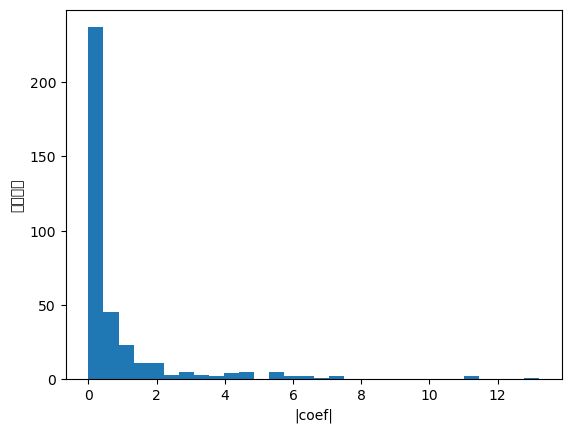

篩選後 R²: 0.09154773567220986


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(X)

lr = LinearRegression()
lr.fit(Xp, y)
print("原始 R²:", lr.score(Xp, y))

# SelectFromModel 篩選特徵
sm = SelectFromModel(lr, threshold="median")
Xt = sm.fit_transform(Xp, y)
sm.estimator_.score(Xp, y)

lr2 = LinearRegression().fit(Xt, y)
print("篩選後 R²:", lr2.score(Xt, y))